In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline


In [3]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [4]:
train_df.head(3)


,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1


In [5]:
train_df.shape

(100000, 76)

# Exploratory Data Analysis (EDA)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [7]:
num_cols = train_df.select_dtypes(include=['number']).columns

num_cols

Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID',
       'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite',
       'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode',
       'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID',
       'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID',
       'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges',
       'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID',
       'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled',
       'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled',
       'IsVirtua

In [8]:
cat_cols = train_df.select_dtypes(include=['object']).columns

cat_cols

Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion',
       'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName',
       'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType', 'ChassisType',
       'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch',
       'OSEdition', 'OSSkuFriendlyName', 'OSInstallType',
       'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing', 'DateAS', 'DateOS'],
      dtype='object')

In [9]:
num_count = len(num_cols)
cat_count = len(cat_cols)

print("No. of Numerical Columns:",num_count)
print("No. of Categorical Columns:",cat_count)

No. of Numerical Columns: 48
No. of Categorical Columns: 28


In [10]:
train_df.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,100000.0,99934.000000,100000.000000,99924.000000,99924.000000,99924.000000,100000.000000,100000.000000,99377.000000,100000.000000,...,99624.000000,99666.000000,100000.000000,99980.000000,100000.000000,100000.000000,99866.000000,99441.000000,99441.000000,100000.000000
mean,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,...,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,0.505250
std,0.0,1.015166,0.131566,13803.321533,0.520681,0.155291,0.056654,63.062151,48944.027074,89.188929,...,221.318891,21151.970827,0.499984,0.061855,0.334614,0.197316,0.234496,0.456791,4.562533,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,...,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36694.000000,89.000000,...,142.000000,13020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,...,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122835.000000,267.000000,...,556.000000,52357.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000
max,0.0,8.000000,1.000000,70490.000000,5.000000,4.000000,1.000000,222.000000,167957.000000,296.000000,...,1083.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


In [11]:
missing_values_sum = train_df.isnull().sum()

missing_values_sum

MachineID             0
ProductName           0
EngineVersion         0
AppVersion            0
SignatureVersion      0
                   ... 
IsGamer             559
RegionIdentifier    559
DateAS                0
DateOS               24
target                0
Length: 76, dtype: int64

In [12]:
columns_with_missing_values = missing_values_sum[missing_values_sum > 0]

print("The no. of columns with missing values",len(columns_with_missing_values))

The no. of columns with missing values 33


In [13]:
columns_with_missing_values

RealTimeProtectionState                66
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
CityID                                623
IsSystemProtected                      76
SMode                                 981
IEVersionID                           107
FirewallEnabled                       166
EnableLUA                              19
OEMNameID                             212
OEMModelID                            228
ProcessorCoreCount                     85
ProcessorManufacturerID                85
ProcessorModelID                       85
PrimaryDiskCapacityMB                 110
PrimaryDiskType                        23
SystemVolumeCapacityMB                110
TotalPhysicalRAMMB                    151
ChassisType                             2
PrimaryDisplayDiagonalInches           72
PrimaryDisplayResolutionHorizontal     72
PrimaryDisplayResolutionVertical       72
InternalBatteryNumberOfCharges    

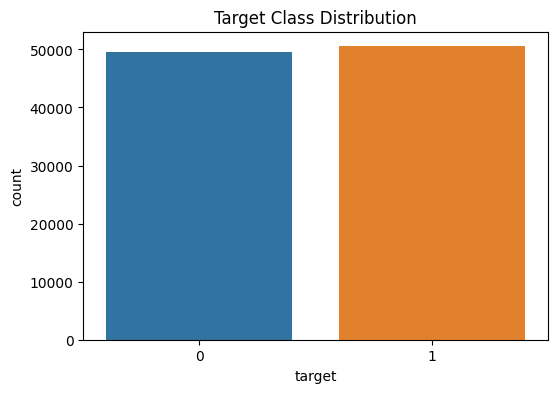

In [14]:
# Visualizing class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=train_df['target'])
plt.title("Target Class Distribution")
plt.show()

The give dataset is a **balanced dataset** as the count for both the classes are almost equal

In [15]:
train_df['target'].value_counts()

target
1    50525
0    49475
Name: count, dtype: int64

<Figure size 2000x4800 with 0 Axes>

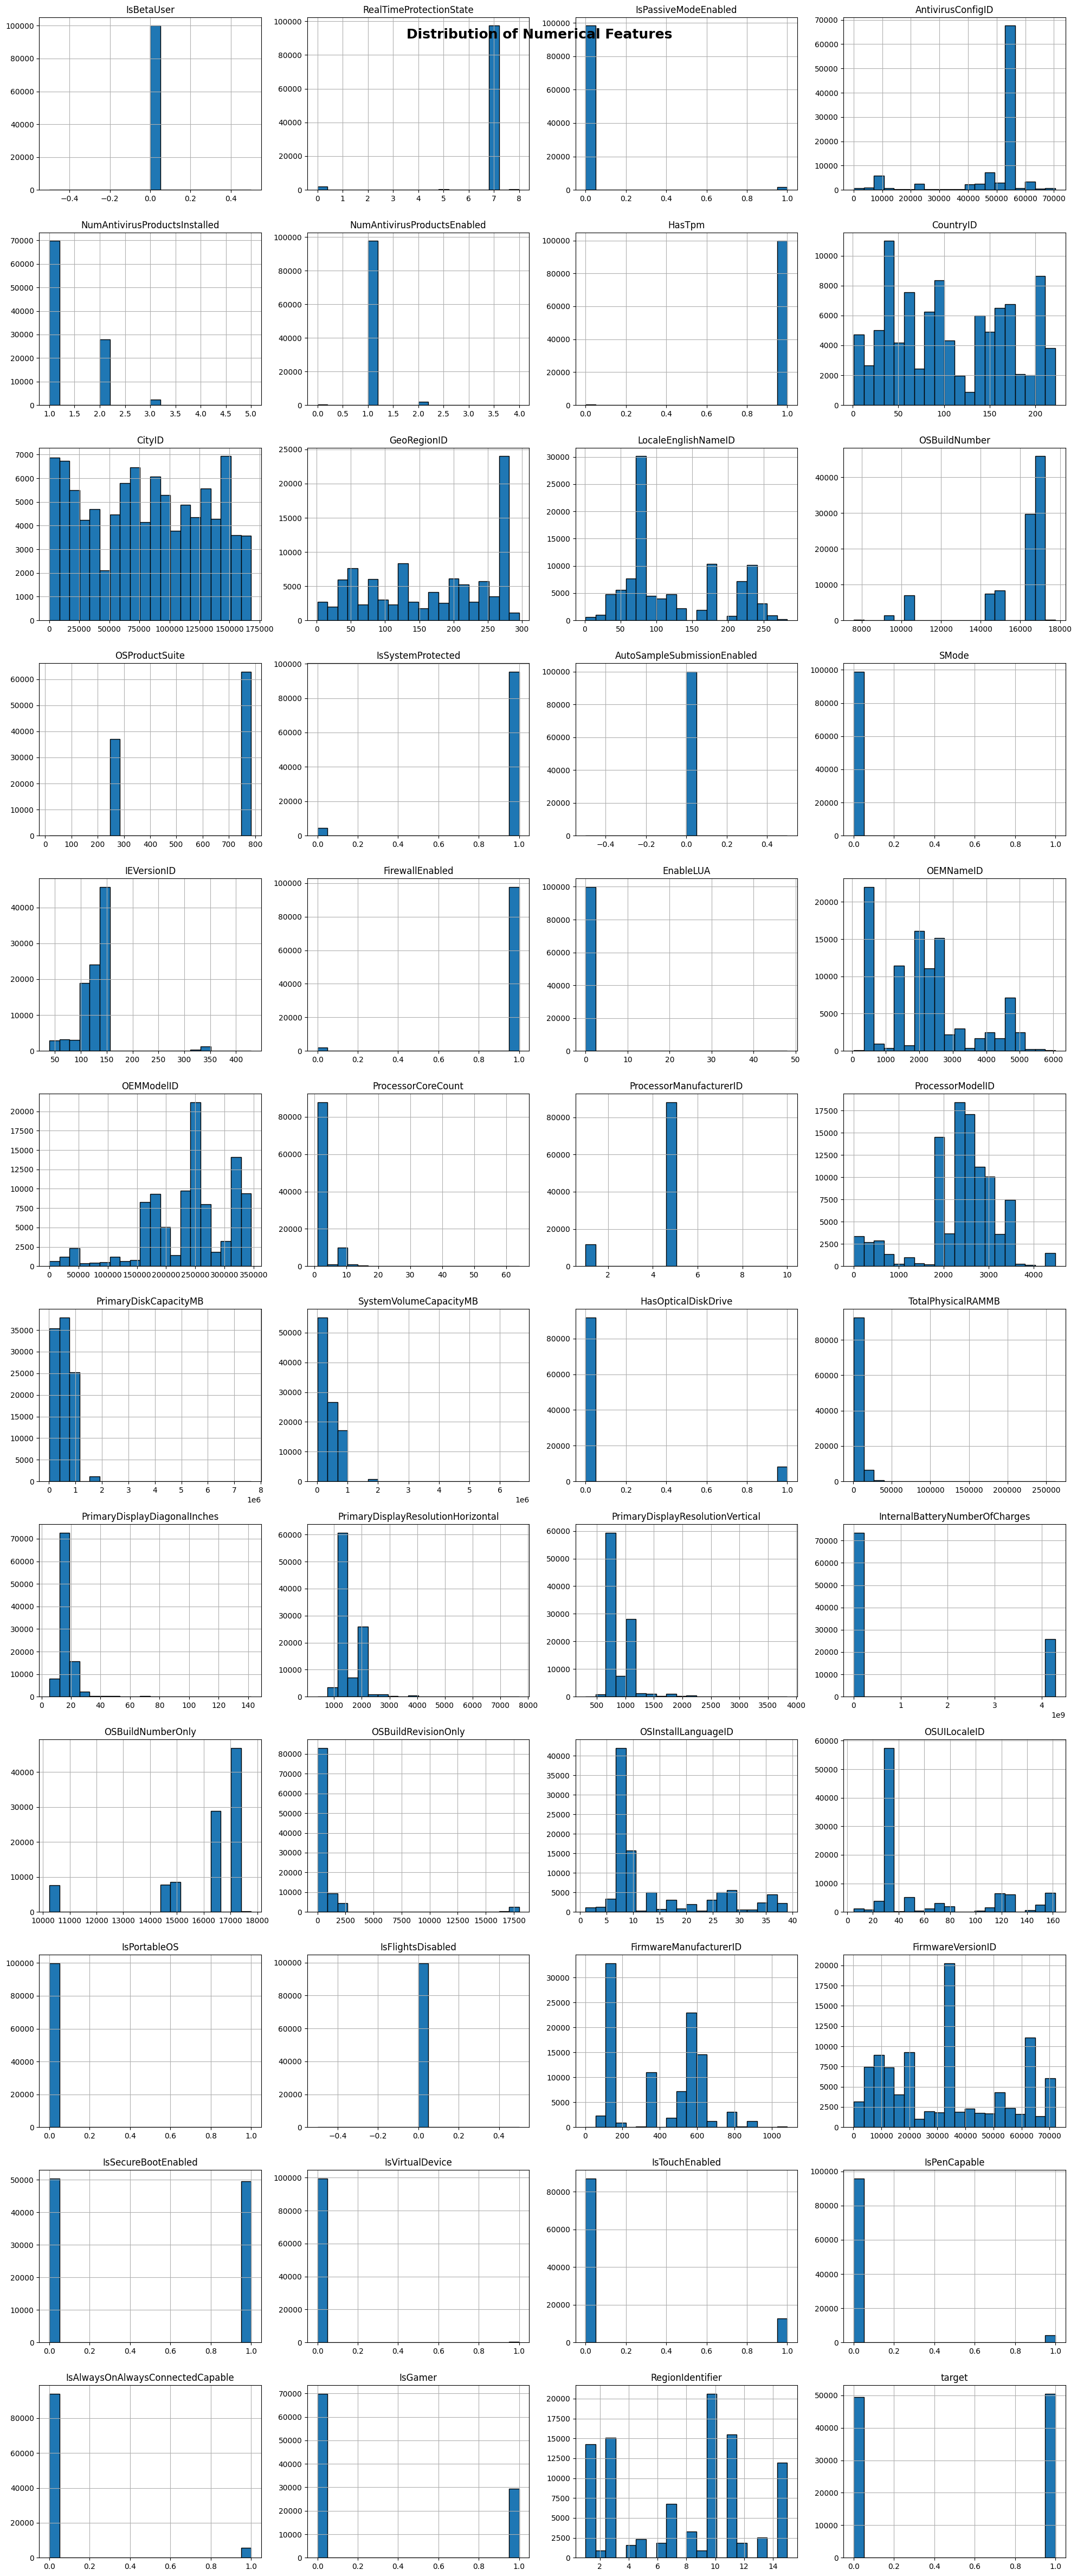

In [16]:
#Histograms for knowing the distribution of the features
num_features = len(num_cols)
rows = (num_features // 4) + (num_features % 4 > 0) 

plt.figure(figsize=(20, rows * 4)) 
train_df[num_cols].hist(figsize=(20, rows * 4), bins=20, layout=(rows, 4), edgecolor='black')

plt.suptitle('Distribution of Numerical Features', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


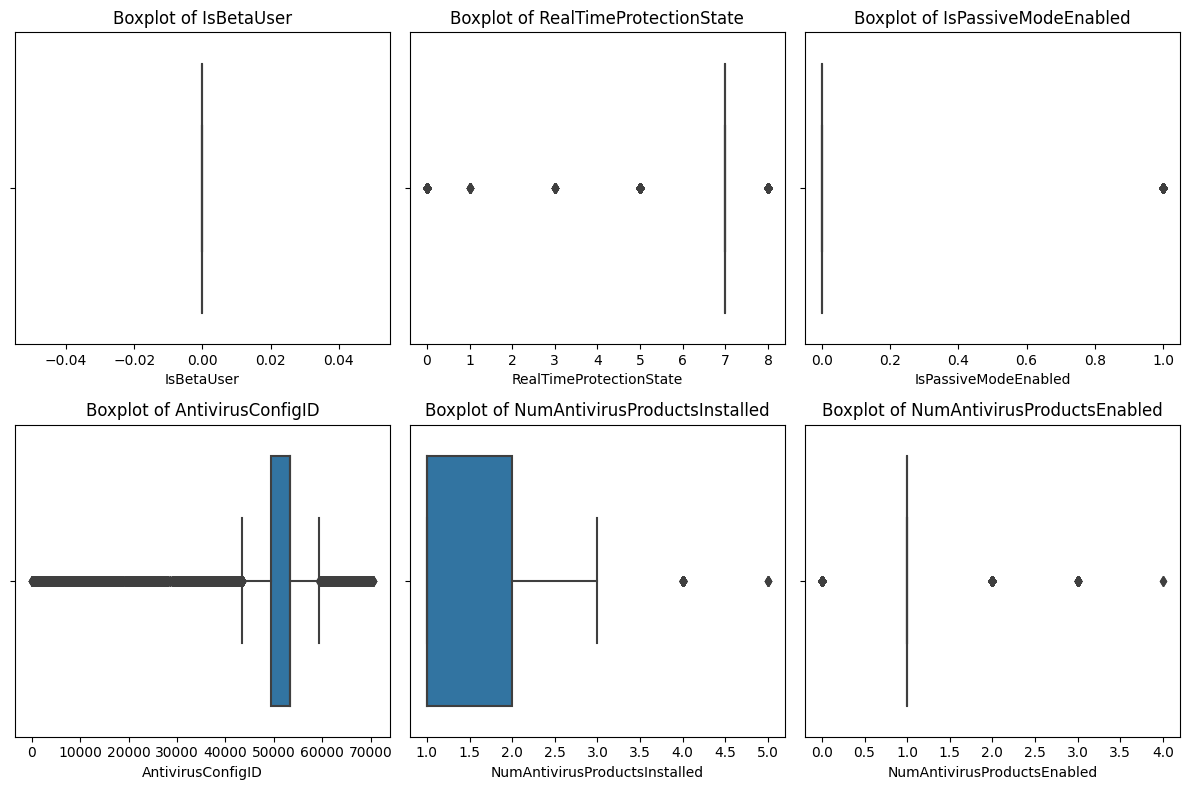

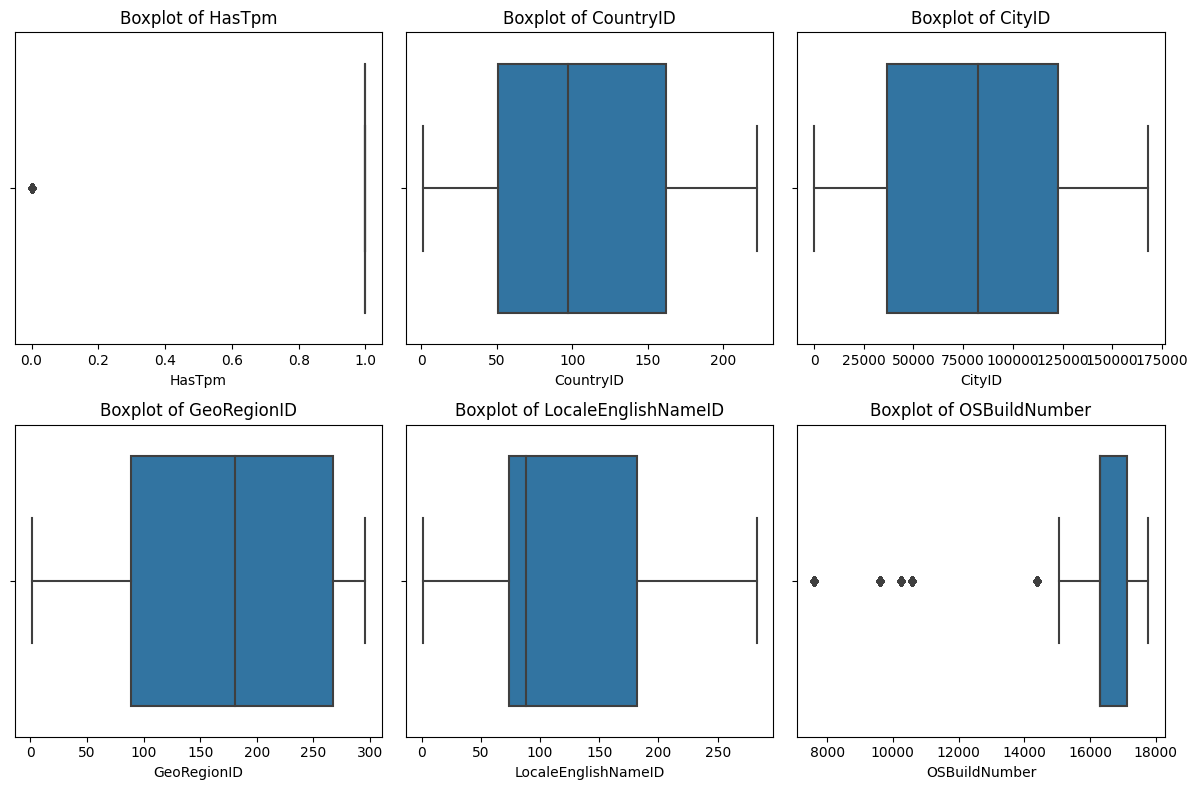

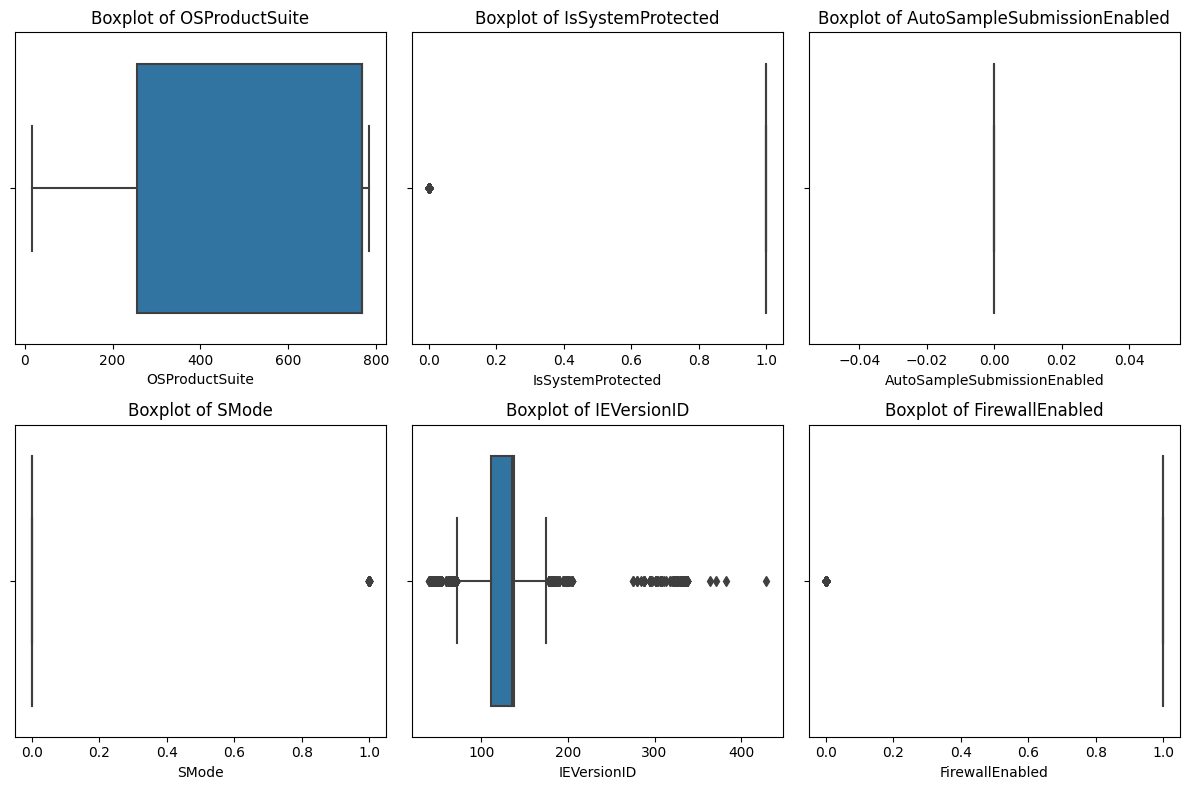

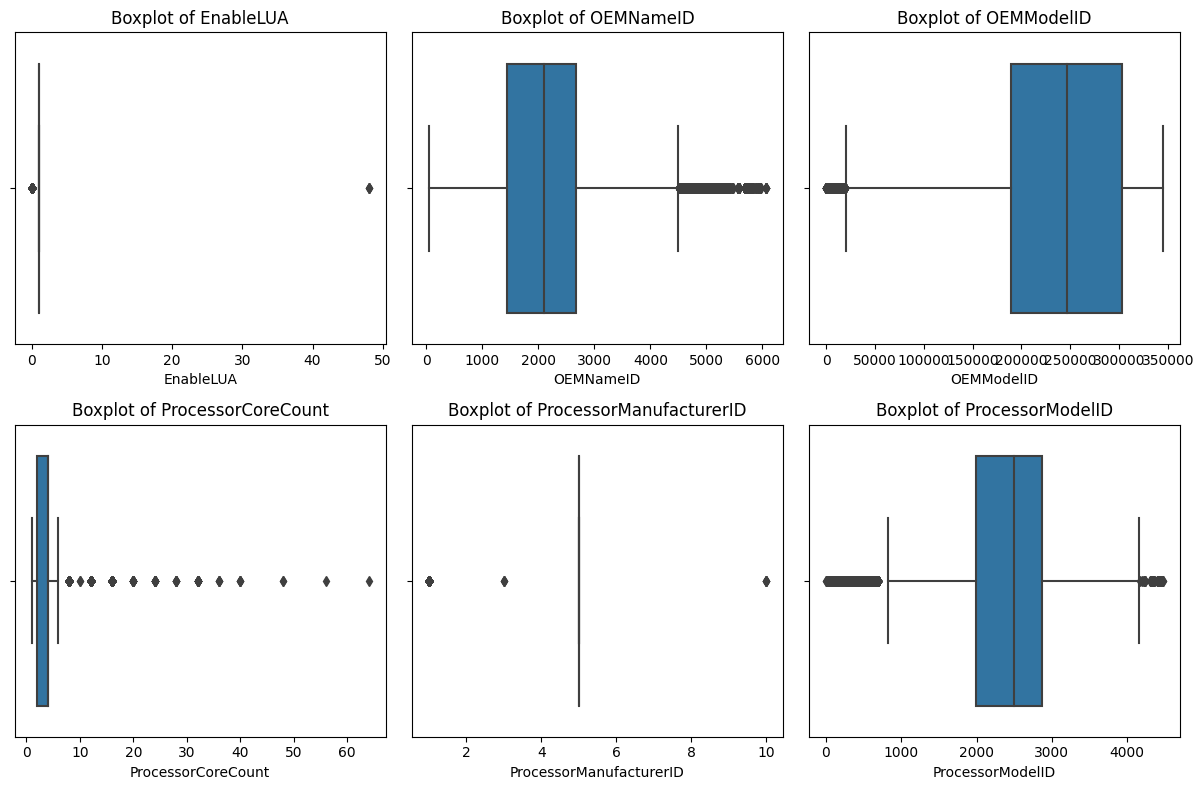

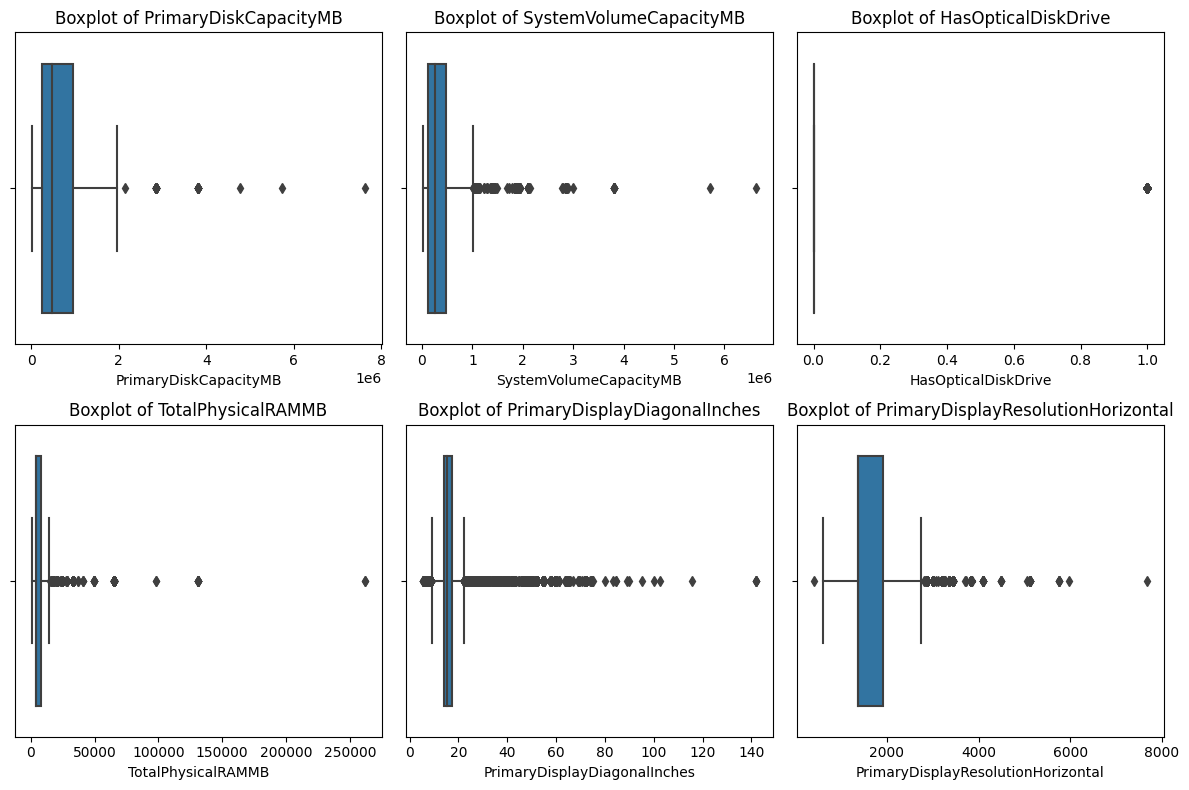

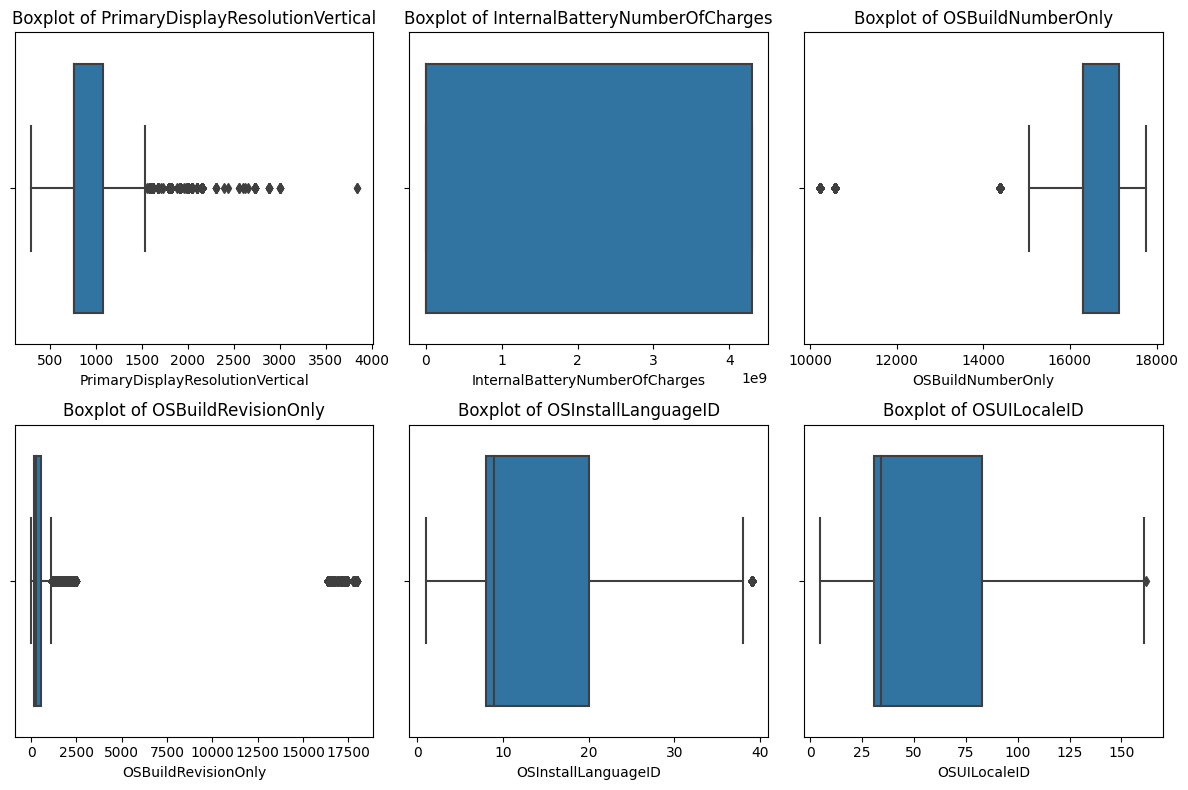

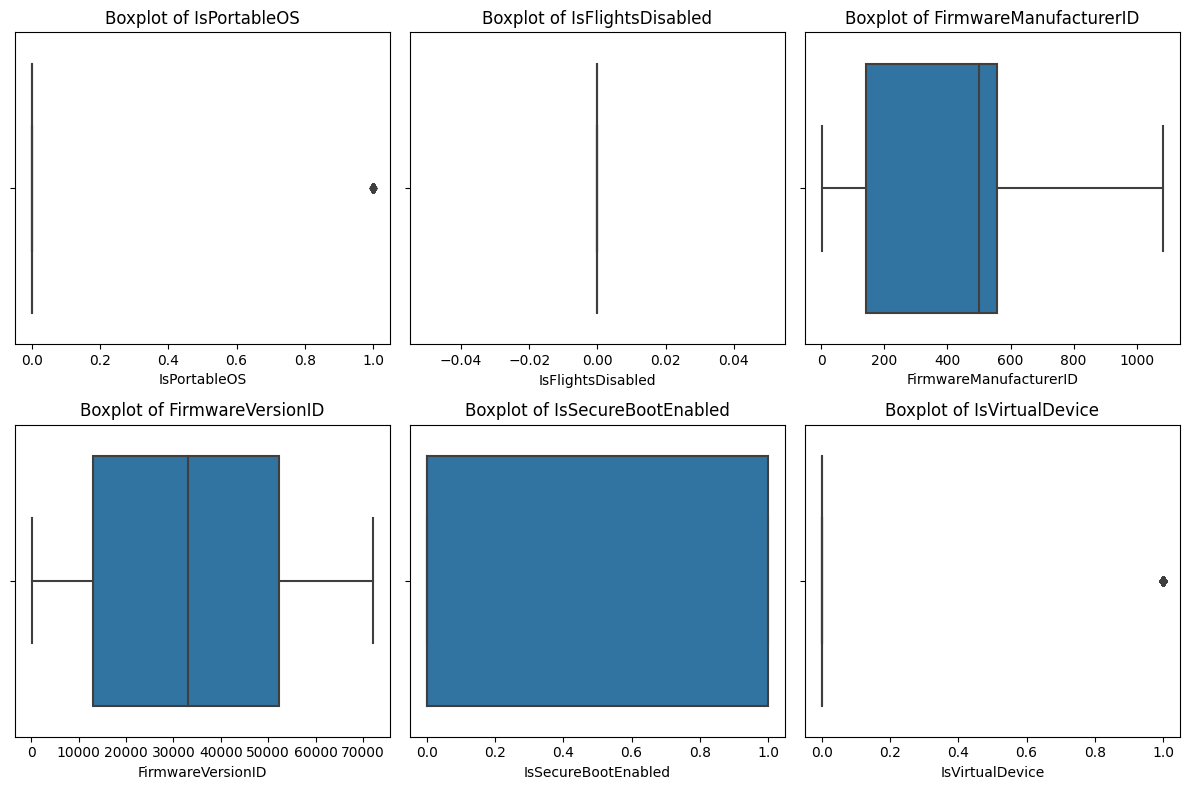

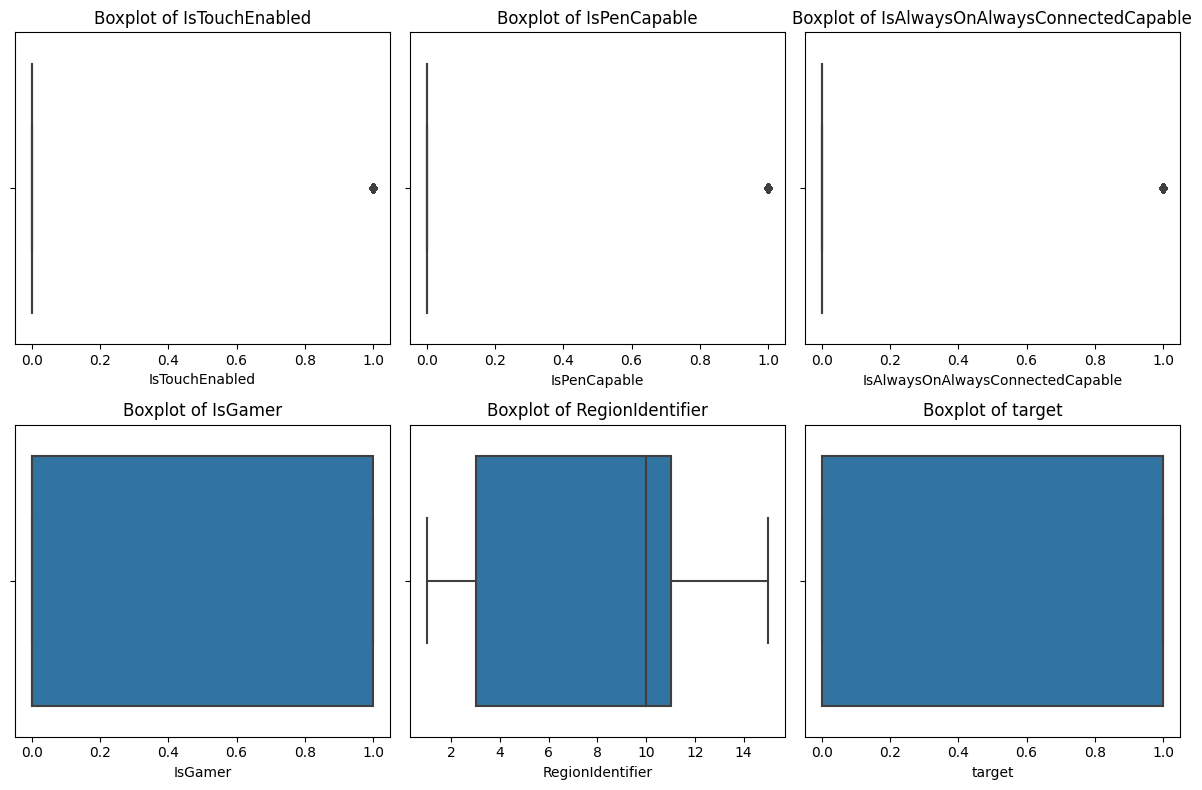

In [17]:
num_cols = train_df.select_dtypes(include=['number']).columns
num_plots_per_fig = 6 

for batch_start in range(0, len(num_cols), num_plots_per_fig):
    batch_cols = num_cols[batch_start:batch_start + num_plots_per_fig]  

    plt.figure(figsize=(12, 8))
    for i, col in enumerate(batch_cols, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=train_df[col])
        plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()


In [18]:
# correlation matrix
perfect_cols = train_df.drop(columns=["IsBetaUser", "AutoSampleSubmissionEnabled", "IsFlightsDisabled","DeviceFamily"])
# perfect_cols
numeric_cols = perfect_cols.select_dtypes(include=['number'])
plt.figure(figsize=(100,100))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


# Preprocessing

In [19]:
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [20]:
# Encoding categorical features
Ordinal_Encoder = {}
for col in train_df.select_dtypes(include=['object']).columns:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
    train_df[col] = oe.fit_transform(train_df[[col]].astype(str))
    test_df[col] = oe.transform(test_df[[col]].astype(str))
    Ordinal_Encoder[col] = oe

In [21]:
# Removing unwanted features
numeric_cols = train_df.select_dtypes(include=['number'])
correlation = numeric_cols.corr()["target"].abs().dropna().sort_values(ascending=False)
important_features = correlation[correlation > 0.01].index.tolist()
important_features.remove("target")



In [22]:
# Extract features and target
X = train_df[important_features]
y = train_df['target']

In [23]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:

X_train_scaled = preprocessing_pipeline.fit_transform(X_train)

In [25]:
X_test_scaled = preprocessing_pipeline.transform(X_test)

In [26]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Model Training

RandomForest Accuracy: 0.6169
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      9878
           1       0.62      0.63      0.63     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



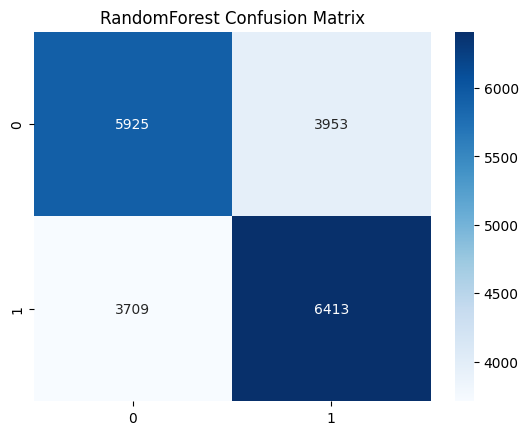

LogisticRegression Accuracy: 0.5944
              precision    recall  f1-score   support

           0       0.61      0.50      0.55      9878
           1       0.58      0.68      0.63     10122

    accuracy                           0.59     20000
   macro avg       0.60      0.59      0.59     20000
weighted avg       0.60      0.59      0.59     20000



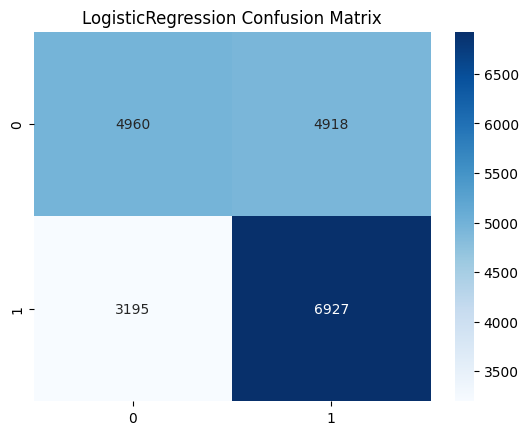

XGBoost Accuracy: 0.6238
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      9878
           1       0.62      0.66      0.64     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



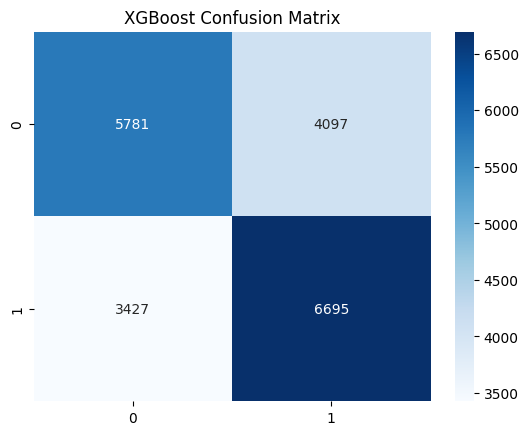

Best Model: XGBoost with Accuracy: 0.6238


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
])


models = {
    "RandomForest": Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "LogisticRegression": Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    "XGBoost": Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}

results = {}
best_model = None
best_accuracy = 0.0

for name, pipeline in models.items():

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Update best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = name

print(f"Best Model: {best_model} with Accuracy: {best_accuracy:.4f}")


# HPT for best model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'classifier__subsample': 1.0, 'classifier__n_estimators': 500, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.6}
Best Cross-Validated Accuracy: 0.6294625
Test Set Accuracy with Best Model: 0.63125
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      9878
           1       0.63      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



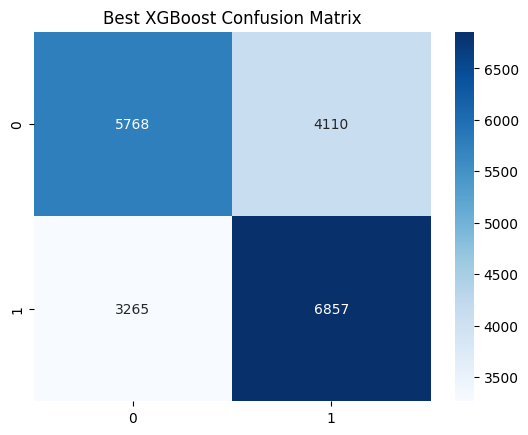

In [28]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 500],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__gamma': [0, 0.1, 0.2, 0.5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50, 
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_pipeline = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

y_pred_best = best_pipeline.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_best)
print("Test Set Accuracy with Best Model:", final_accuracy)
print(classification_report(y_test, y_pred_best, zero_division=0))

sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title("Best XGBoost Confusion Matrix")
plt.show()


In [31]:
X_test = X_test[X_train.columns]
X_test_encoded = pd.get_dummies(X_test)
X_test_encoded = X_test_encoded.reindex(columns=X_train.columns, fill_value=0) 
y_pred = best_pipeline.predict(X_test_encoded)
submission = pd.DataFrame({"id": range(len(y_pred)), "target": y_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")


Submission file 'submission.csv' created successfully!
